In [ ]:
import torch
from torch import nn
import os
from os import path
import torchvision
import torchvision.transforms as T
from typing import Sequence
from torchvision.transforms import functional as F
from torchvision.datasets import OxfordIIITPet
import numbers
import random
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
#!pip install torchmetrics
import torchmetrics as TM
from tqdm import tqdm

In [6]:
tensorToImg = T.ToPILImage()
imgToTensor = T.ToTensor()
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

def to_device(x):
    if torch.cuda.is_available():
        return x.cuda()
    else:
        return x.cpu()

def get_model_parameters(m):
    total_params = sum(
        param.numel() for param in m.parameters()
    )
    return total_params

def print_model_parameters(m):
    num_model_parameters = get_model_parameters(m)
    print(f"The Model has {num_model_parameters/1e6:.2f}M parameters")

def close_figures():
    while len(plt.get_fignums()) > 0:
        plt.close()

print(f"CUDA: {torch.cuda.is_available()}")

CUDA: True


In [8]:
trainPath = os.path.join('./data', 'OxfordPets')
testPath = os.path.join('./data', 'OxfordPets')
trainData = OxfordIIITPet(
    root= trainPath,
    split= 'trainval',
    target_types= 'segmentation',
    download= True)
TestData = OxfordIIITPet(
    root= testPath,
    split= 'test',
    target_types= 'segmentation',
    download= True)

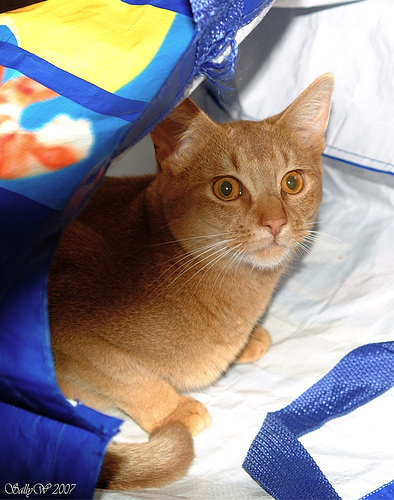

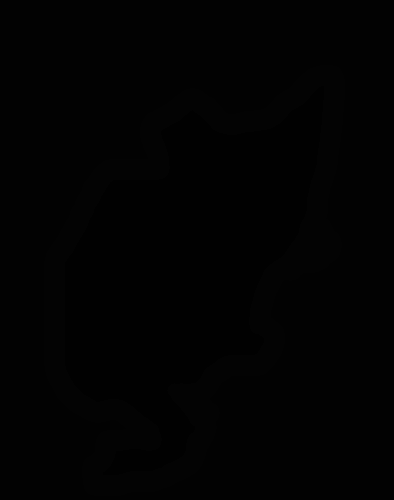

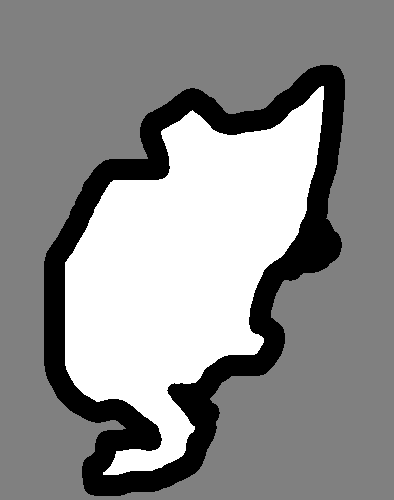

In [9]:
(trainImage, trainTarget) = trainData[0]
display(trainImage)
display(trainTarget)
trainTarget.putpalette([
    0,0,0,
    255,255,255,
    128,128,128,
])
trainTarget

In [10]:
from enum import IntEnum
class TrimapClasses(IntEnum):
    PET = 0
    BACKGROUND = 1
    BORDER = 2

class ToDevice(torch.nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, img):
        return img.to(self.device)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(device={device})"

In [11]:
class OxfordIIITPetsSegmentation(OxfordIIITPet):
    def __init__(
        self,
        root: str,
        split: str,
        target_types="segmentation",
        download = False,
        preTransform = None,
        postTransform = None,
        preTargetTransform= None,
        postTargetTransform = None,
        commonTransform = None,
    ):
        super().__init__(
            root = root,
            split = split,
            target_types = target_types,
            download = download,
            transform = preTransform,
            target_transform = preTargetTransform,
        )
        self.postTransform = postTransform
        self.postTargetTransform = postTargetTransform
        self.commonTransform = commonTransform

    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):
        (input, target) = super().__getitem__(idx)

        both = torch.cat([input, target], dim=0)
        both = self.commonTransform(both)
        (input, target) = torch.split(both, 3, dim=0)

        input = self.postTransform(input)
        target = self.postTargetTransform(target)

        return (input, target)

In [12]:
def tensor_trimap(t):
    x = t * 255
    x = x.to(torch.long)
    x = x - 1
    return x
    
def args_to_dict(**kwargs):
    return kwargs
    
transform_dict = args_to_dict(
    preTransform = T.ToTensor(),
    preTargetTransform = T.ToTensor(),
    commonTransform = T.Compose([
        ToDevice(get_device()),
        T.Resize((128, 128), interpolation = T.InterpolationMode.NEAREST),
        T.RandomHorizontalFlip(p=0.5),
    ]),
    postTransform = T.Compose([
        T.ColorJitter(contrast=0.3),
    ]),
    postTargetTransform = T.Compose([
        T.Lambda(tensor_trimap),
    ]),
)

trainData = OxfordIIITPetsSegmentation(
    root= trainPath,
    split="trainval",
    target_types="segmentation",
    download=False,
    **transform_dict,
)
testData = OxfordIIITPetsSegmentation(
    root= testPath,
    split= "test",
    target_types= "segmentation",
    download= False,
    **transform_dict,
)

trainLoader = DataLoader(trainData, batch_size= 64,shuffle=True)
testloader = DataLoader(testData, batch_size= 24, shuffle=True)

(trainImage, trainTarget) = next(iter(trainLoader))
(testImage, testTarget) = next(iter(testloader))
trainImage.shape, trainTarget.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 1, 128, 128]))

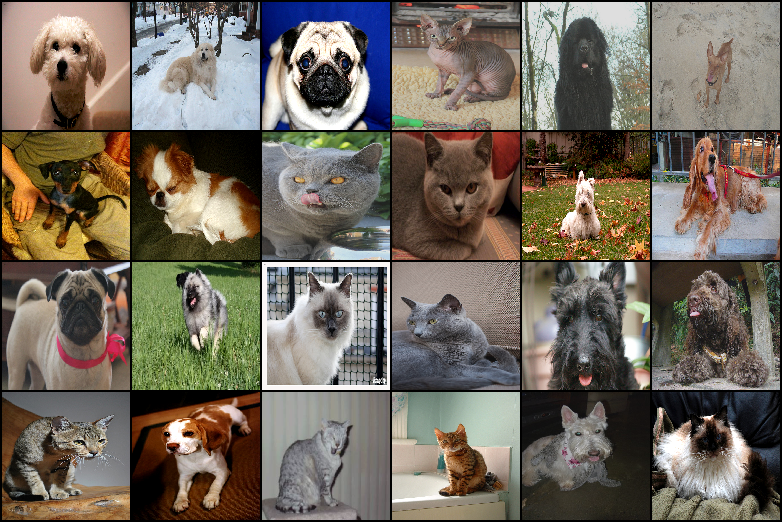

In [13]:
imageGrid = torchvision.utils.make_grid(testImage, nrow=6)
tensorToImg(imageGrid)

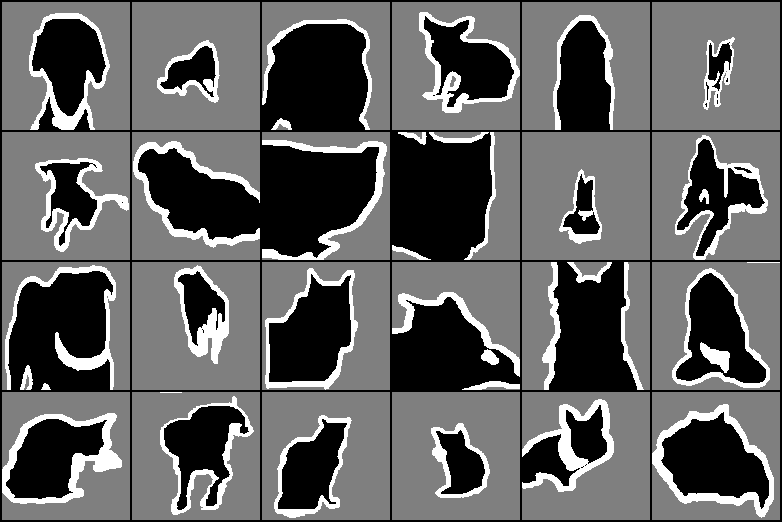

In [14]:
targetGrid = torchvision.utils.make_grid(testTarget / 2, nrow=6)
tensorToImg(targetGrid)

In [15]:
class DownConv2(nn.Module):
    def __init__(self, chin, chout):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels = chin, out_channels = chout, kernel_size= 3, padding= 1, bias= False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
            nn.Conv2d(in_channels=chout, out_channels = chout, kernel_size= 3, padding = 1, bias= False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mp = nn.MaxPool2d(kernel_size = 2, return_indices = True)

    def forward(self, x):
        y = self.seq(x)
        pool_shape = y.shape
        y, indices = self.mp(y)
        return y, indices, pool_shape

class DownConv3(nn.Module):
    def __init__(self, chin, chout):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels= chin, out_channels= chout, kernel_size = 3, padding= 1, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
            nn.Conv2d(in_channels= chout, out_channels= chout, kernel_size= 3, padding= 1, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
            nn.Conv2d(in_channels= chout, out_channels= chout, kernel_size= 3, padding= 1, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mp = nn.MaxPool2d(kernel_size= 2, return_indices= True)

    def forward(self, x):
        y = self.seq(x)
        pool_shape = y.shape
        y, indices = self.mp(y)
        return y, indices, pool_shape

class UpConv2(nn.Module):
    def __init__(self, chin, chout):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=chin, out_channels=chin, kernel_size= 3, padding= 1, bias=False),
            nn.BatchNorm2d(chin),
            nn.ReLU(),
            nn.Conv2d(in_channels=chin, out_channels=chout, kernel_size= 3, padding= 1, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mup = nn.MaxUnpool2d(kernel_size= 2)

    def forward(self, x, indices, output_size):
        y = self.mup(x, indices, output_size = output_size)
        y = self.seq(y)
        return y

class UpConv3(nn.Module):
    def __init__(self, chin, chout):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=chin, out_channels=chin, kernel_size= 3, padding= 1, bias=False),
            nn.BatchNorm2d(chin),
            nn.ReLU(),
            nn.Conv2d(in_channels=chin, out_channels=chin, kernel_size= 3, padding= 1, bias=False),
            nn.BatchNorm2d(chin),
            nn.ReLU(),
            nn.Conv2d(in_channels=chin, out_channels=chout, kernel_size= 3, padding= 1, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mup = nn.MaxUnpool2d(kernel_size=2)

    def forward(self, x, indices, output_size):
        y = self.mup(x, indices, output_size = output_size)
        y = self.seq(y)
        return y


class ImageSegmentation(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.out_channels = 3
        self.bn_input = nn.BatchNorm2d(3)
        self.dc1 = DownConv2(3, 64)
        self.dc2 = DownConv2(64, 128)
        self.dc3 = DownConv3(128, 256)
        self.dc4 = DownConv3(256, 512)

        self.uc4 = UpConv3(512, 256)
        self.uc3 = UpConv3(256, 128)
        self.uc2 = UpConv2(128, 64)
        self.uc1 = UpConv2(64, 3)

    def forward(self, batch: torch.Tensor):
        x = self.bn_input(batch)
        x, mp1_indices, shape1 = self.dc1(x)
        x, mp2_indices, shape2 = self.dc2(x)
        x, mp3_indices, shape3 = self.dc3(x)
        x, mp4_indices, shape4 = self.dc4(x)

        x = self.uc4(x, mp4_indices, output_size=shape4)
        x = self.uc3(x, mp3_indices, output_size=shape3)
        x = self.uc2(x, mp2_indices, output_size=shape2)
        out = self.uc1(x, mp1_indices, output_size=shape1)

        return out

In [38]:
model = ImageSegmentation()
model.eval()
to_device(model)
model(to_device(trainImage)).shape

torch.Size([64, 3, 128, 128])

<img src="./Net.png" />

In [40]:
from torchinfo import summary

summary(model, input_size = (1,3,128,128))

Layer (type:depth-idx)                   Output Shape              Param #
ImageSegmentation                        [1, 3, 128, 128]          --
├─BatchNorm2d: 1-1                       [1, 3, 128, 128]          6
├─DownConv2: 1-2                         [1, 64, 64, 64]           --
│    └─Sequential: 2-1                   [1, 64, 128, 128]         --
│    │    └─Conv2d: 3-1                  [1, 64, 128, 128]         1,728
│    │    └─BatchNorm2d: 3-2             [1, 64, 128, 128]         128
│    │    └─ReLU: 3-3                    [1, 64, 128, 128]         --
│    │    └─Conv2d: 3-4                  [1, 64, 128, 128]         36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 128, 128]         128
│    │    └─ReLU: 3-6                    [1, 64, 128, 128]         --
│    └─MaxPool2d: 2-2                    [1, 64, 64, 64]           --
├─DownConv2: 1-3                         [1, 128, 32, 32]          --
│    └─Sequential: 2-3                   [1, 128, 64, 64]          --
│    │ 

In [39]:
to_device(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.7)

In [41]:
def prediction_accuracy(ground_truth_labels, predicted_labels):
    eq = ground_truth_labels == predicted_labels
    return eq.sum().item() / predicted_labels.numel()

def print_test_dataset_masks(model, test_pets_targets, test_pets_labels, epoch, show_plot):
    to_device(model.eval())
    predictions = model(to_device(test_pets_targets))
    test_pets_labels = to_device(test_pets_labels)
    pred = nn.Softmax(dim=1)(predictions)

    pred_labels = pred.argmax(dim=1)
    pred_labels = pred_labels.unsqueeze(1)
    pred_mask = pred_labels.to(torch.float)

    iou = to_device(TM.classification.MulticlassJaccardIndex(3, average='micro', ignore_index=TrimapClasses.BACKGROUND))
    iou_accuracy = iou(pred_mask, test_pets_labels)
    pixel_metric = to_device(TM.classification.MulticlassAccuracy(3, average='micro'))
    pixel_accuracy = pixel_metric(pred_labels, test_pets_labels)
    title = f'Epoch: {epoch:02d}, Accuracy[Pixel: {pixel_accuracy:.4f}, IoU: {iou_accuracy:.4f}]'
    print(title)

    close_figures()

    fig = plt.figure(figsize=(40, 20))
    fig.suptitle(title, fontsize=12)

    fig.add_subplot(3, 1, 1)
    plt.imshow(tensorToImg(torchvision.utils.make_grid(test_pets_targets, nrow=6)))
    plt.axis('off')
    plt.title("Targets")

    fig.add_subplot(3, 1, 2)
    plt.imshow(tensorToImg(torchvision.utils.make_grid(test_pets_labels.float() / 2.0, nrow=6)))
    plt.axis('off')
    plt.title("Real Labels")

    fig.add_subplot(3, 1, 3)
    plt.imshow(tensorToImg(torchvision.utils.make_grid(pred_mask / 2.0, nrow=6)))
    plt.axis('off')
    plt.title("Predicted Labels")

    if show_plot is False:
        close_figures()
    else:
        plt.show()

In [42]:
def test_dataset_accuracy(model, loader):
    to_device(model.eval())
    iou = to_device(TM.classification.MulticlassJaccardIndex(3, average='micro', ignore_index=TrimapClasses.BACKGROUND))
    pixel_metric = to_device(TM.classification.MulticlassAccuracy(3, average='micro'))

    iou_accuracies = []
    pixel_accuracies = []
    custom_iou_accuracies = []

    print_model_parameters(model)

    for batch_idx, (inputs, targets) in enumerate(loader, 0):
        inputs = to_device(inputs)
        targets = to_device(targets)
        predictions = model(inputs)

        pred_probabilities = nn.Softmax(dim=1)(predictions)
        pred_labels = predictions.argmax(dim=1)

        pred_labels = pred_labels.unsqueeze(1)
        pred_mask = pred_labels.to(torch.float)

        iou_accuracy = iou(pred_mask, targets)
        pixel_accuracy = pixel_metric(pred_labels, targets)
        iou_accuracies.append(iou_accuracy.item())
        pixel_accuracies.append(pixel_accuracy.item())

        del inputs
        del targets
        del predictions

    iou_tensor = torch.FloatTensor(iou_accuracies)
    pixel_tensor = torch.FloatTensor(pixel_accuracies)
    custom_iou_tensor = torch.FloatTensor(custom_iou_accuracies)

    print("Test Dataset Accuracy")
    print(f"Pixel Accuracy: {pixel_tensor.mean():.4f}, IoU Accuracy: {iou_tensor.mean():.4f}")

Epoch: 00, Accuracy[Pixel: 0.3109, IoU: 0.5872]


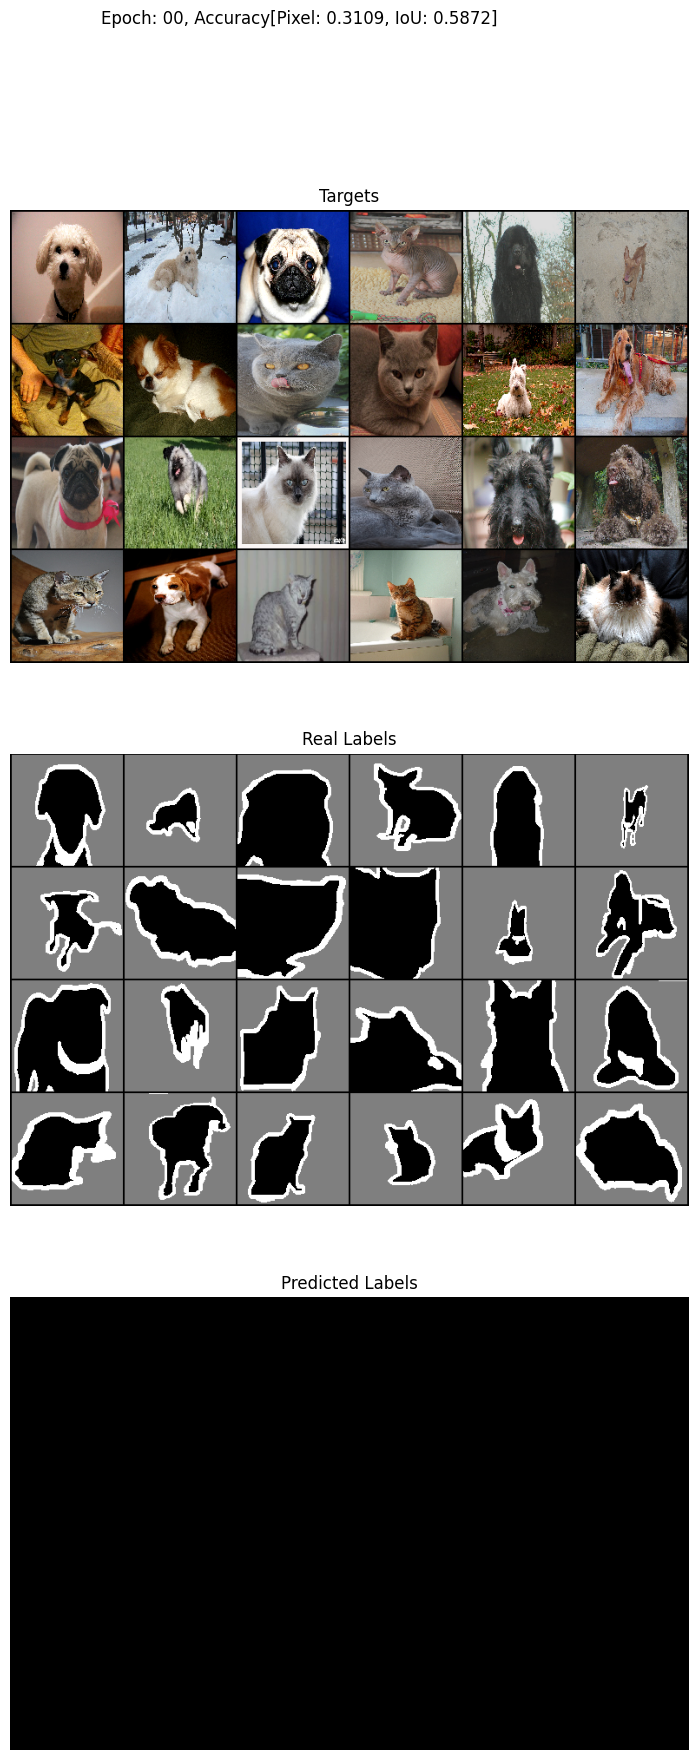

In [43]:
print_test_dataset_masks(model, testImage, testTarget, epoch=0, show_plot=True)

In [44]:
def train_loop(model, loader, test_data, epochs, optimizer, scheduler):
    test_inputs, test_targets = test_data
    epoch_start, epoch_end = epochs
    loss_func = nn.CrossEntropyLoss(reduction='mean')

    for epoch in range(epoch_start, epoch_end):
        current_lr = optimizer.param_groups[0]['lr']
        tqdm.write(f"Epoch: {epoch + 1:02d}, Learning Rate: {current_lr:.6f}")

        model.train()
        running_loss = 0.0

        with tqdm(loader, desc=f"Epoch {epoch + 1} Batches", leave=True, unit="batch") as batch_pbar:
            for batch_idx, (inputs, targets) in enumerate(batch_pbar, 1):
                optimizer.zero_grad()
                inputs = to_device(inputs)
                targets = to_device(targets)
                outputs = model(inputs)

                targets = targets.squeeze(dim=1)
                loss = loss_func(outputs, targets)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                if batch_idx % 10 == 0 or batch_idx == len(loader):
                    avg_loss = running_loss / batch_idx
                    batch_pbar.set_postfix(loss=f"{avg_loss:.4f}")

        avg_epoch_loss = running_loss / len(loader)
        batch_pbar.set_postfix(loss= running_loss / (batch_pbar.n + 1) )

        with torch.inference_mode():
            print_test_dataset_masks(
                model, 
                test_inputs, 
                test_targets, 
                epoch=epoch + 1, 
                show_plot=(epoch + 1 == epoch_end)
            )


        scheduler.step()

    print("Training Complete.\n")

Epoch: 01, Learning Rate: 0.001000


Epoch 1 Batches: 100%|██████████| 58/58 [00:37<00:00,  1.55batch/s, loss=0.9795]


Epoch: 01, Accuracy[Pixel: 0.6211, IoU: 0.5429]
Epoch: 02, Learning Rate: 0.001000


Epoch 2 Batches: 100%|██████████| 58/58 [00:36<00:00,  1.57batch/s, loss=0.8270]


Epoch: 02, Accuracy[Pixel: 0.6538, IoU: 0.5439]
Epoch: 03, Learning Rate: 0.001000


Epoch 3 Batches: 100%|██████████| 58/58 [00:36<00:00,  1.57batch/s, loss=0.7931]


Epoch: 03, Accuracy[Pixel: 0.7043, IoU: 0.5339]
Epoch: 04, Learning Rate: 0.001000


Epoch 4 Batches: 100%|██████████| 58/58 [00:37<00:00,  1.55batch/s, loss=0.7595]


Epoch: 04, Accuracy[Pixel: 0.7523, IoU: 0.5115]
Epoch: 05, Learning Rate: 0.001000


Epoch 5 Batches: 100%|██████████| 58/58 [00:36<00:00,  1.57batch/s, loss=0.7314]


Epoch: 05, Accuracy[Pixel: 0.6828, IoU: 0.5524]
Epoch: 06, Learning Rate: 0.001000


Epoch 6 Batches: 100%|██████████| 58/58 [00:36<00:00,  1.57batch/s, loss=0.6882]


Epoch: 06, Accuracy[Pixel: 0.7751, IoU: 0.5842]
Epoch: 07, Learning Rate: 0.001000


Epoch 7 Batches: 100%|██████████| 58/58 [00:37<00:00,  1.57batch/s, loss=0.6534]


Epoch: 07, Accuracy[Pixel: 0.8140, IoU: 0.5869]
Epoch: 08, Learning Rate: 0.000700


Epoch 8 Batches: 100%|██████████| 58/58 [00:37<00:00,  1.54batch/s, loss=0.6254]


Epoch: 08, Accuracy[Pixel: 0.8255, IoU: 0.6032]
Epoch: 09, Learning Rate: 0.000700


Epoch 9 Batches: 100%|██████████| 58/58 [00:36<00:00,  1.57batch/s, loss=0.5990]


Epoch: 09, Accuracy[Pixel: 0.8231, IoU: 0.6287]
Epoch: 10, Learning Rate: 0.000700


Epoch 10 Batches: 100%|██████████| 58/58 [00:36<00:00,  1.57batch/s, loss=0.5725]


Epoch: 10, Accuracy[Pixel: 0.8234, IoU: 0.6248]
Epoch: 11, Learning Rate: 0.000700


Epoch 11 Batches: 100%|██████████| 58/58 [00:37<00:00,  1.56batch/s, loss=0.5484]


Epoch: 11, Accuracy[Pixel: 0.8560, IoU: 0.6600]
Epoch: 12, Learning Rate: 0.000700


Epoch 12 Batches: 100%|██████████| 58/58 [00:37<00:00,  1.54batch/s, loss=0.5220]


Epoch: 12, Accuracy[Pixel: 0.8439, IoU: 0.6861]
Epoch: 13, Learning Rate: 0.000700


Epoch 13 Batches: 100%|██████████| 58/58 [00:37<00:00,  1.55batch/s, loss=0.5064]


Epoch: 13, Accuracy[Pixel: 0.8539, IoU: 0.6952]
Epoch: 14, Learning Rate: 0.000700


Epoch 14 Batches: 100%|██████████| 58/58 [00:37<00:00,  1.57batch/s, loss=0.4846]


Epoch: 14, Accuracy[Pixel: 0.8674, IoU: 0.6834]
Epoch: 15, Learning Rate: 0.000490


Epoch 15 Batches: 100%|██████████| 58/58 [00:37<00:00,  1.54batch/s, loss=0.4644]


Epoch: 15, Accuracy[Pixel: 0.8607, IoU: 0.6719]
Epoch: 16, Learning Rate: 0.000490


Epoch 16 Batches: 100%|██████████| 58/58 [00:38<00:00,  1.52batch/s, loss=0.4518]


Epoch: 16, Accuracy[Pixel: 0.8724, IoU: 0.7111]
Epoch: 17, Learning Rate: 0.000490


Epoch 17 Batches: 100%|██████████| 58/58 [00:37<00:00,  1.55batch/s, loss=0.4391]


Epoch: 17, Accuracy[Pixel: 0.8745, IoU: 0.7115]
Epoch: 18, Learning Rate: 0.000490


Epoch 18 Batches: 100%|██████████| 58/58 [00:36<00:00,  1.57batch/s, loss=0.4295]


Epoch: 18, Accuracy[Pixel: 0.8725, IoU: 0.7025]
Epoch: 19, Learning Rate: 0.000490


Epoch 19 Batches: 100%|██████████| 58/58 [00:37<00:00,  1.56batch/s, loss=0.4151]


Epoch: 19, Accuracy[Pixel: 0.8750, IoU: 0.6886]
Epoch: 20, Learning Rate: 0.000490


Epoch 20 Batches: 100%|██████████| 58/58 [00:37<00:00,  1.55batch/s, loss=0.4069]


Epoch: 20, Accuracy[Pixel: 0.8825, IoU: 0.7097]


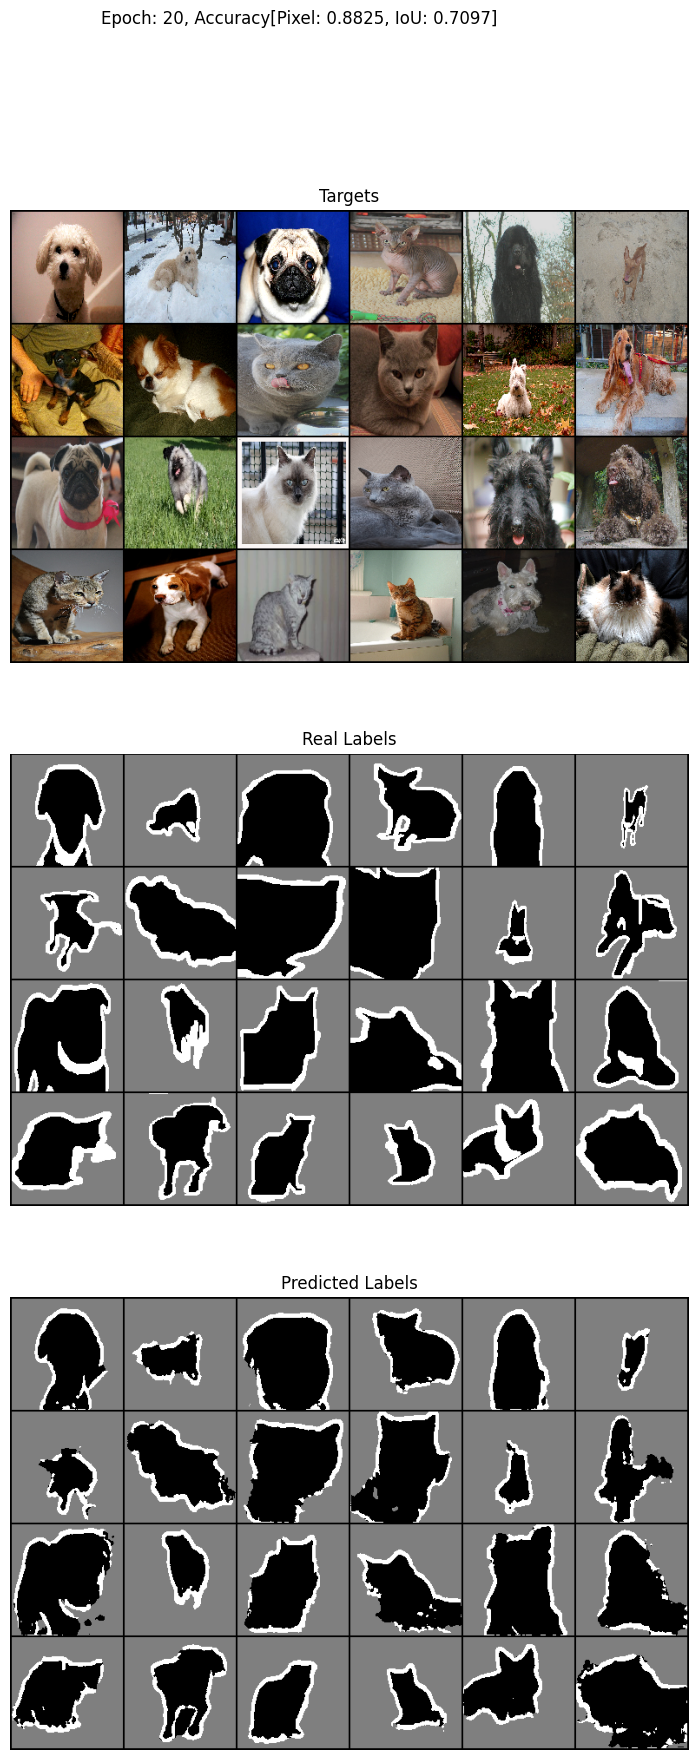

Training Complete.



In [45]:
train_loop(model, trainLoader, (testImage, testTarget), (0, 20), optimizer, scheduler)